In [55]:
import pandas as pd
import netCDF4 
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.pyplot as plt
from copulas.multivariate import GaussianMultivariate
from copulas.multivariate import VineCopula
from copulas.visualization import compare_3d
from copulas.visualization import scatter_3d
from sklearn.preprocessing import MinMaxScaler
from copulas.univariate import GaussianUnivariate



# Import data

In [ ]:
import cdsapi

dataset = ""
request = {
    "variable": [
      
    ],
    "experiment": "ERA5 reanalysis",
    "year": []
}
client = cdsapi.Client()
client.retrieve(dataset, request).download()


# Explore

In [3]:
data_folder = "data"
netcdf_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(".nc")]

In [4]:
netcdf_files

['data\\07_warmest_three_day_period-reanalysis-yearly-grid-1940-2023-v1.0.nc',
 'data\\09_heat_waves_climatological-reanalysis-yearly-grid-1940-2023-v1.0.nc',
 'data\\11_frost_days-reanalysis-yearly-grid-1940-2023-v1.0.nc',
 'data\\13_maximum_five_days_precipitation-reanalysis-yearly-grid-1940-2023-v1.0.nc',
 'data\\14_extreme_precipitation_total-reanalysis-yearly-grid-1940-2023-v1.0.nc',
 'data\\15_frequency_of_extreme_precipitation-reanalysis-yearly-grid-1940-2023-v1.0.nc',
 'data\\19_duration_of_meteorological_droughts-reanalysis-yearly-grid-1940-2023-v1.0.nc',
 'data\\22_days_with_high_fire_danger-reanalysis-yearly-grid-1979-2021-v1.0.nc',
 'data\\24_extreme_wind_speed_days-reanalysis-yearly-grid-1940-2023-v1.0.nc']

In [11]:
import xarray as xr
dry= xr.open_dataset("data\\19_duration_of_meteorological_droughts-reanalysis-yearly-grid-1940-2023-v1.0.nc")
hot= xr.open_dataset("data\\07_warmest_three_day_period-reanalysis-yearly-grid-1940-2023-v1.0.nc")
wind= xr.open_dataset("data\\24_extreme_wind_speed_days-reanalysis-yearly-grid-1940-2023-v1.0.nc")



In [16]:
hot

<xarray.Dataset> Size: 17MB
Dimensions:      (time: 84, lat: 185, lon: 271)
Coordinates:
  * time         (time) datetime64[ns] 672B 1940-01-01 1941-01-01 ... 2023-01-01
    realization  int64 8B ...
  * lat          (lat) float64 1kB 26.5 26.75 27.0 27.25 ... 72.0 72.25 72.5
  * lon          (lon) float64 2kB -22.0 -21.75 -21.5 -21.25 ... 45.0 45.25 45.5
Data variables:
    t2m          (time, lat, lon) float32 17MB ...

# Copule multivarié

In [113]:
lat_sel = 43
lon_sel = 0

dry_data = dry['dmd']
hot_data = hot['t2m']
wind_data = wind['data']

# Fusionner les datasets sur les dimensions communes (time, lat, lon)
combined = xr.merge([dry_data.rename('dry'), 
                     hot_data.rename('hot'), 
                     wind_data.rename('wind')])

# Extraire les données pour cette localisation (utilise l'indexation la plus proche)
location_data = combined.sel(lat=lat_sel, lon=lon_sel, method="nearest")

# Convertir en DataFrame avec les années comme index
df = location_data.to_dataframe().reset_index()

# Garde uniquement les colonnes qui nous intéressent
df = df[['time', 'dry', 'hot', 'wind']]

# Optionnel : convertir 'time' en année si tu préfères
df['year'] = df['time'].dt.year
df = df.drop(columns='time')

# Réorganiser les colonnes
df = df[['year', 'dry', 'hot', 'wind']]


In [114]:
def uniformize_data(df, columns):
    """
    Transforme chaque colonne du DataFrame en pseudo-observations uniformes [0,1]
    Utilisé pour ajuster une copule.

    Args:
        df (pd.DataFrame): DataFrame contenant les colonnes à transformer.
        columns (list): Liste des noms de colonnes à transformer.

    Returns:
        np.ndarray: Tableau numpy transformé (n, d)
    """
    n = len(df)
    u = np.zeros((n, len(columns)))

    for i, col in enumerate(columns):
        ranks = df[col].rank(method='average')  # méthode 'average' pour être stable
        u[:, i] = ranks / (n + 1)  # normalisation sur [0,1]

    return u

# Exemple d’utilisation :
columns = ['dry', 'hot', 'wind']
df_normalized =pd.DataFrame(uniformize_data(df, columns), columns=columns)


In [115]:
df_normalized

,dry,hot,wind
0,0.211765,0.176471,0.376471
1,0.870588,0.988235,0.905882
2,0.935294,0.705882,0.147059
3,0.841176,0.435294,0.147059
4,0.935294,0.505882,0.241176
...,...,...,...
79,0.723529,0.952941,0.970588
80,0.211765,0.905882,0.558824
81,0.552941,0.835294,0.241176
82,0.211765,0.964706,0.558824


In [132]:

copula = VineCopula("center")
copula.fit(df_normalized)
synthetic_data = copula.sample(len(df_normalized))

c:\Users\lucas\OneDrive\Documents\M2 MSOEF\Data mining\projet kaggle\.venv\lib\site-packages\copulas\multivariate\vine.py:78: UserWarning:

Vines have not been fully tested on Python >= 3.8 and might produce wrong results.

c:\Users\lucas\OneDrive\Documents\M2 MSOEF\Data mining\projet kaggle\.venv\lib\site-packages\copulas\bivariate\base.py:163: RuntimeWarning:

Data does not appear to be uniform.



In [133]:
copula_params = copula.to_dict()
copula_params.keys()

dict_keys(['type', 'vine_type', 'fitted', 'n_sample', 'n_var', 'depth', 'truncated', 'trees', 'tau_mat', 'u_matrix', 'unis', 'columns'])

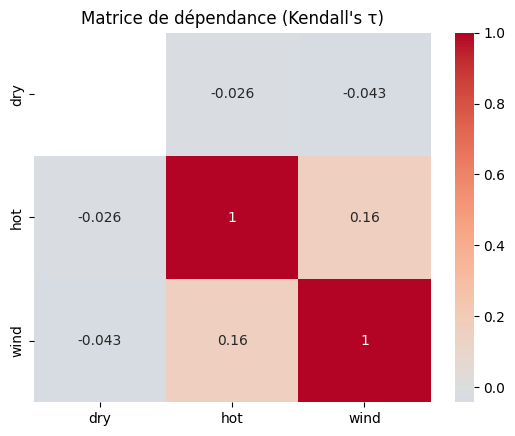

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

tau_mat = np.array(copula_params['tau_mat'])
labels = ['dry', 'hot', 'wind']

sns.heatmap(tau_mat, annot=True, xticklabels=labels, yticklabels=labels, cmap='coolwarm', center=0)
plt.title("Matrice de dépendance (Kendall's τ)")
plt.show()


In [119]:
copula_params['type']

'copulas.multivariate.vine.VineCopula'

In [123]:
# scatter_3d(df.iloc[:,1:])
scatter_3d(df_normalized)

In [125]:

compare_3d(df_normalized, synthetic_data)